**Problem:** When the generate code has to process molecules with different number of hydrogens, it has to load a precompiled binary to IPU which takes around 1 second. 

**Solution:** Initially sort all molecules by number of hydrogen atoms => each ipu only has to do something like 1 reload. 

Finding
- the code didn't have "upper" when translating smiles to atoms; this meant it sometimes throws away atoms, e.g., "c" != "C. 
- gdb9 has 440k SMILES strings but only 130k species? what are species? read GDB9 abstract. 
- sorting may allow us to (partially) remove padding in the generate code? 
- taking out energy from the csv files is tricky because atom positions (and thus column/entry of energy) varies. 
- some SMILEs strings has only 8 atoms (~20); removing those. 

In [68]:
from tqdm import tqdm 
from rdkit import Chem  
from rdkit.Chem import AllChem
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

#smiles = [a.split("\t")[0] for a in open("gdb11_size09.smi", "r").read().split("\n")][:1024]
smiles = [a.split("\t")[0] for a in open("gdb11_size09.smi", "r").read().split("\n")]

smiles_9 = []

num_hs = []
for smile in tqdm(smiles):
  atoms = [a for a in list(smile.upper()) if a == "C" or a == "N" or a == "O" or a == "F"]
  if len(atoms) != 9: continue 
  smiles_9.append(smile)
  b = Chem.MolFromSmiles(smile)
  b = Chem.AddHs(b) 
  atoms = [atom.GetSymbol() for atom in b.GetAtoms()]
  num_hs.append( len([a for a in atoms if a.upper() == "H"]))

100%|██████████| 444314/444314 [01:49<00:00, 4062.97it/s]


In [69]:
import numpy as np 
num_hs = np.array(num_hs)
sorted_smiles = np.array(smiles_9)[np.argsort(num_hs)].tolist()

In [70]:
from tqdm import tqdm 
from rdkit import Chem  
from rdkit.Chem import AllChem

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

pbar = tqdm(sorted_smiles)

sorted_num_hs = []
for i, smile in enumerate(pbar): 
  atoms = [a for a in list(smile.upper()) if a == "C" or a == "N" or a == "O" or a == "F"]
  if len(atoms) != 9: continue 
  b = Chem.MolFromSmiles(smile)
  b = Chem.AddHs(b) 
  atoms = [atom.GetSymbol() for atom in b.GetAtoms()]
  hs =  len([a for a in atoms if a.upper() == "H"])
  if i % 10000 == 0: pbar.set_description(str(hs))
  sorted_num_hs.append(hs)


16: 100%|██████████| 444285/444285 [01:53<00:00, 3908.57it/s]


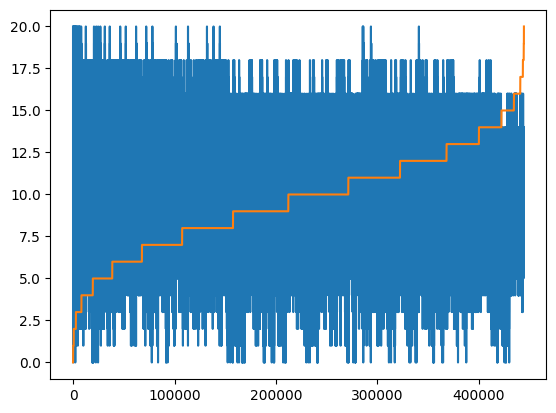

In [71]:
import matplotlib.pyplot as plt 

plt.plot(num_hs)
plt.plot(sorted_num_hs)

In [73]:
sorted_num_hs = np.array(sorted_num_hs)
print(np.sum(sorted_num_hs[1:] != sorted_num_hs[:-1])) # check it only changes 20 times, once for each added hydrogen! 

20


In [74]:
import pandas as pd
df = pd.DataFrame(sorted_smiles[1:])
df.to_csv('gdb11_size09_sorted.csv', index=False, header=False)

In [53]:
!less gdb11_size09_sorted.csv

07=
[O-][N+](=O)c1nnon1
N#CC#Cc1nnon1
Fc1nc(=O)nc(F)o1
Fc1onc2onnc12
N#Cc1noc(n1)C#N
Fc1nc2onnc2o1
O=c1onc2onnn12
Fc1onnc(=O)c1F
Fc1onc2OC(=O)c12
FC(C#N)=C(C#N)C#N
Fc1nc(=O)c(F)no1
[O-][N+](=O)c1onnc1F
[O-][N+](=O)c1nnc(F)o1
O=C1OC(=O)C(=O)C1=O
FC(F)(F)c1nnno1
Fc1nc(=O)oc(=O)o1
N#CC(C#N)(C#N)C#N
Fc1nc(oc1F)C#N
Fc1nonc(F)c1=O
N#Cc1nnc(o1)C#N
O=c1nnnnc(=O)o1
O=C(C#N)c1nnno1
:11_size09_sorted.csv

In [58]:
# one of the molecules had only 8 atoms, remove those check thi 
# they basically included hydrogens in the SMILEs string. 
# we remove theese. 
num_atoms = []
for smile in tqdm(smiles):
  atoms = [a for a in list(smile.upper()) if a == "C" or a == "N" or a == "O" or a == "F"]

  if len(atoms) != 9: print(smile, list(smile), atoms)
  num_atoms.append(len(atoms))

 95%|█████████▍| 420551/444314 [00:01<00:00, 439932.23it/s]

[O-][N+](=O)c1ccc[nH]1 ['[', 'O', '-', ']', '[', 'N', '+', ']', '(', '=', 'O', ')', 'c', '1', 'c', 'c', 'c', '[', 'n', 'H', ']', '1'] ['O', 'N', 'O', 'C', 'C', 'C', 'C', 'N']
[O-][N+](=O)c1c[nH]cn1 ['[', 'O', '-', ']', '[', 'N', '+', ']', '(', '=', 'O', ')', 'c', '1', 'c', '[', 'n', 'H', ']', 'c', 'n', '1'] ['O', 'N', 'O', 'C', 'C', 'N', 'C', 'N']
[O-][N+](=O)c1cc[nH]n1 ['[', 'O', '-', ']', '[', 'N', '+', ']', '(', '=', 'O', ')', 'c', '1', 'c', 'c', '[', 'n', 'H', ']', 'n', '1'] ['O', 'N', 'O', 'C', 'C', 'C', 'N', 'N']
[O-][N+](=O)c1cnn[nH]1 ['[', 'O', '-', ']', '[', 'N', '+', ']', '(', '=', 'O', ')', 'c', '1', 'c', 'n', 'n', '[', 'n', 'H', ']', '1'] ['O', 'N', 'O', 'C', 'C', 'N', 'N', 'N']
[O-][N+](=O)c1ncc[nH]1 ['[', 'O', '-', ']', '[', 'N', '+', ']', '(', '=', 'O', ')', 'c', '1', 'n', 'c', 'c', '[', 'n', 'H', ']', '1'] ['O', 'N', 'O', 'C', 'N', 'C', 'C', 'N']
[O-][N+](=O)c1nc[nH]n1 ['[', 'O', '-', ']', '[', 'N', '+', ']', '(', '=', 'O', ')', 'c', '1', 'n', 'c', '[', 'n', 'H', ']', '

100%|██████████| 444314/444314 [00:01<00:00, 419157.95it/s]

 [] []


In [67]:
# one of the molecules had only 8 atoms, remove those check thi 
# they basically included hydrogens in the SMILEs string. 
# we remove theese. 
num_atoms = []
for smile in tqdm(sorted_smiles):
  atoms = [a for a in list(smile.upper()) if a == "C" or a == "N" or a == "O" or a == "F"]

  if len(atoms) != 9: print(smile, list(smile), atoms)
  num_atoms.append(len(atoms))

100%|██████████| 1024/1024 [00:00<00:00, 316038.80it/s]


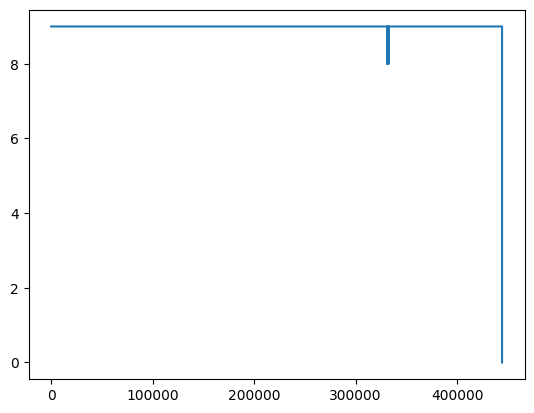

In [56]:
plt.plot(num_atoms)